# Домашнее задание 1.2. Обучение сетей на Pytorch. Numpy-имплементация многослойной нейронной сети



**Разработчик: Артём Бабенко**


В этом задании необходимо будет самостоятельно реализовать нейронную сеть и обучить ее с помощью метода обратного распространения ошибки.

In [5]:
import numpy as np

In [6]:
# Load dependencies
!wget --quiet --show-progress "https://raw.githubusercontent.com/mryab/dl-hse-ami/master/week01_intro/util.py"

util.py             100%[===================>]   3,97K  --.-KB/s    in 0,001s  


Сначала определим базовый класс Layer с основными методами .forward() и .backward().

In [4]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)

    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)

    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # An identity layer does nothing
        pass

    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # An identity layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.

        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):

        d loss / d x  = (d loss / d layer) * (d layer / d x)

        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.

        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of an identity layer is precisely grad_output
        input_dim = input.shape[1]

        d_layer_d_input = np.eye(input_dim)

        return np.dot(grad_output, d_layer_d_input) # chain rule

### Дальнейший план

В этом задании необходимо построить нейросеть для классификации рукописных цифр. Для этого понадобится реализовать следующее:
- ReLU слой
- Полносвязный слой, $f(X)=W \cdot X + b$
- Функцию потерь, для задачи классификации - cross-entropy
- Алгоритм обратного распространения ошибки

Далее вам необходимо будет реализовать каждый из пунктов выше, пользуяюсь предоставленными сниппетами кода.


### Dropout слой
При большой внутренней размерности train и valid сильно расходятся. Чтобы избежать переобучения нужно вставить слой propout.

In [5]:
class Dropout(Layer):
    def __init__(self, rate):
        self.rate = rate
        self.mask = None
        self.train = True
    
    def forward(self, input):
        if not self.train:
            return input
        # Store mask for the backward
        self.mask = np.random.rand(*np.shape(input)) > self.rate # boolean mask
        return input * self.mask / (1.0 - self.rate)
    
    def backward(self, input, grad_output):
        # Same as default layer but without some values
        return grad_output * self.mask
    
    def set_train(self, train):
        self.train = train

### Batchnorm
В данном случае будет реализован слой, который нормалльзует входные батчи в соответствии с обучаемыми параметрами.

In [33]:
class BatchNorm(Layer):
    def __init__(self, input_size, momentum=0.5, e=1e-5, learning_rate=0.1):
        # Parameter which doesn't allow zero division
        self.e = e
        self.learning_rate = learning_rate
        # Momentum is needed for exp mean
        self.momentum = momentum
        self.train = True
        
        # Parameters to be learned for each input dimension
        # First axis is batch size in the input, 
        # but since we work with means this dimension will be 1
        self.gamma = np.ones((1, input_size))
        self.beta = np.zeros((1, input_size))

        # Means for inference
        self.run_mean = np.zeros((1, input_size))
        self.run_div = np.zeros((1, input_size))
    
    def forward(self, input):
        if self.train:
            # These variables should be the same dim as input
            # Axis 0 is a batch size
            batch_mean = np.mean(input, axis=0, keepdims=True) 
            batch_div = np.var(input, axis=0, keepdims=True)

            input_norm = (input - batch_mean) / np.sqrt(batch_div + self.e)
            out = self.gamma * input_norm + self.beta

            self.run_mean = self.momentum * self.run_mean + (1 - self.momentum) * batch_mean
            self.run_div = self.momentum * self.run_div + (1 - self.momentum) * batch_div
        else:
            input_norm = (input - self.run_mean) / np.sqrt(self.run_div + self.e)
            out = self.gamma * input_norm + self.beta
        return out
    
    def backward(self, input, grad_output):
        # Here and below I'm using running values instead of real one
        input_norm = (input - self.run_mean) / np.sqrt(self.run_div + self.e)
        # Sum by batch axis
        dldbeta = np.sum(grad_output, axis=0)

        batch_size = np.shape(input)[0]
        dldx_norm = grad_output * self.gamma
        dlddiv = np.sum(dldx_norm * (input - self.run_mean) * (-0.5) * (self.run_div + self.e)**(-3/2), 
                        axis=0)
        dldmean = np.sum(dldx_norm * (-1) / np.sqrt(self.run_div + self.e), axis=0) + \
            dlddiv * np.sum(-2 * (input - self.run_mean), axis=0) / batch_size
        dldx = dldx_norm / np.sqrt(self.run_div + self.e) + \
            dlddiv * 2 * (input - self.run_mean) / batch_size +\
            dldmean / batch_size

        # Sum by batch axis
        dldbeta = np.sum(grad_output, axis=0)
        dldgamma = np.sum(grad_output * input_norm, axis=0)

        self.gamma = self.gamma - self.learning_rate * dldgamma
        self.beta = self.beta - self.learning_rate * dldbeta
        return dldx

    def set_train(self, train):
        self.train = train       

### ReLU слой
В этом слое применяется поэлементная нелинейность $f(X)=max(X,0)$.

In [8]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass

    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        output = np.array(input)
        output[output < 0] = 0
        return output

    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad_mask = np.zeros_like(input)
        relu_grad_mask[input > 0] = 1
        return grad_output * relu_grad_mask

Для отладки градиентов, вычисленных аналитически, рекомендуется использовать сравнение с градиентами, вычисленными численно, как рассказывалось на лекции. Если вы корректно реализовали методы .forward() и .backward(), то значения градиентов окажутся достаточно близкими. Функция численного подсчета градиентов уже реализована в файле util.py

In [19]:
# some tests
from util import eval_numerical_gradient
points = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(points, np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=points)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

### Полносвязный слой

У полносвязного слоя есть обучаемые параметры: матрица линейного преобразования и столбец свободных членов.

$$f(X)= W \cdot X + b $$

* X - матрица входных данных размера [batch_size, num_features],
* W - матрица преобразования размера [num_features, num_outputs]
* b - столбец свободных членов размера [num_outputs]

W и b необходимо инициализировать во время создания слоя и обновлять при каждом вызове метода .backward().
Для этого слоя вам необходимо реализовать как прямой, так и обратный проход. Формулы для аналитического подсчета градиентов можно взять из лекции, но рекомендуется проверить их самостоятельно на бумаге.

In [9]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate

        # initialize weights with small random numbers from normal distribution
        # you can change the intializtion method
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)

    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b

        input shape: [batch, input_units]
        output shape: [batch, output_units]
        """
        return np.dot(input, self.weights) + self.biases

    def backward(self, input, grad_output):

        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        # grad_output is a derivative of the next (in forward) layer of prediction
        # this result is needed for the next layer
        grad_input = np.dot(grad_output, np.transpose(self.weights))

        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(np.transpose(input), grad_output)
        grad_biases = np.sum(grad_output, axis=0)

        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step.
        # or step of another gradient method
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases

        return grad_input

### Тестирование полносвязного слоя

Три следующих блока тестируют вашу реализацию, если все корректно, вы трижды получите "Well done!"

In [28]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x), np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

Well done!


In [29]:
# To test the grads, we use gradients obtained via finite differences

from util import eval_numerical_gradient

x = np.linspace(-1,1,10*32).reshape([10,32])
l = Dense(32,64,learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

Well done!


In [30]:
#test gradients w.r.t. params
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)

def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases

w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

Well done!


### Функция потерь

Вычисление функции потерь для задачи классификации, а также ее градиента уже сделано для вас.

In [10]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]

    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))

    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1

    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)

    return (- ones_for_answers + softmax) / logits.shape[0]

In [11]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."

NameError: name 'eval_numerical_gradient' is not defined

### Итоговая нейросеть

Все готово для запуска нейросети. Нейросеть будем тестировать на классическом датасете MNIST. Код ниже визуализирует несколько примеров из этого датасета.

In [12]:
import os
import sys
import numpy as np

def load_mnist(flatten=False):
    """taken from https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py"""
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='https://ossci-datasets.s3.amazonaws.com/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

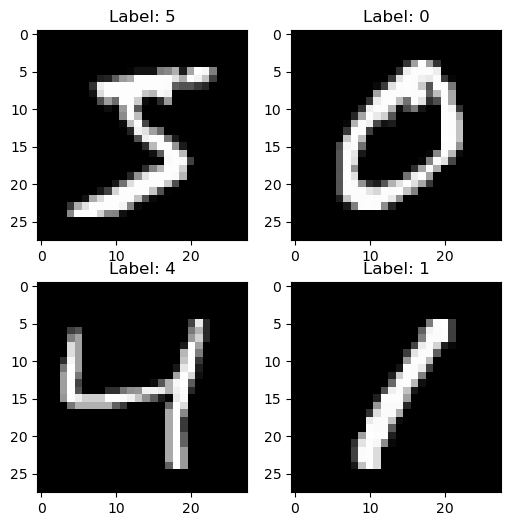

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

В нашей реализации сеть - просто список (Python-list) слоев.

Поварьируйте hidden_layers_size, попробуйте добавить еще скрытые слои, чтобы найти лучшую метрику

In [54]:
network = []
hidden_layers_size = 40
output_size = 10
network.append(Dense(X_train.shape[1], hidden_layers_size))
network.append(BatchNorm(input_size=hidden_layers_size, momentum=0.9, learning_rate=1e-3))
network.append(ReLU())
network.append(Dropout(0.2))
network.append(Dense(hidden_layers_size, output_size))

In [15]:
def set_training(network):
    for layer in network:
        if isinstance(layer, Dropout) or isinstance(layer, BatchNorm):
            layer.set_train(True)

def set_inference(network):
    for layer in network:
        if isinstance(layer, Dropout) or isinstance(layer, BatchNorm):
            layer.set_train(False)

Реализуйте прямой проход по целой сети, последовательно вызывая .forward() для каждого слоя.

In [23]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer.
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X

    for layer in network:
        input = layer.forward(input)
        activations.append(input)

    assert len(activations) == len(network)
    return activations

def predict(network, X):
    """
    Use network to predict the most likely class for each sample.
    """
    set_inference(network)
    logits = forward(network, X)[-1]
    return logits.argmax(axis=-1)

In [24]:
def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.

    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    set_training(network)
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X] + layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]

    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)

    # propagate gradients through network layers using .backward
    # hint: start from last layer and move to earlier layers 
    for i in range(0, len(network)):
       cur_pos = len(network) - 1 - i
       loss_grad = network[cur_pos].backward(layer_inputs[cur_pos], loss_grad)  

   # This is not working
    #for layer, input in zip(reversed(network), reversed(layer_inputs[:-2])):
    #   loss_grad = layer.backward(input, loss_grad) 

    return np.mean(loss)

Все готово для запуска обучения. Если все реализовано корректно, то точность классификации на валидационном множестве **должна превысить** 97%.

Если ваша метрика получилась хуже, попробуйте реализовать следующие пункты:
1. Добавить в шаг изменения весов momentum
2. Попытаться использовать LR Scheduler: то есть, изменять learning rate по некоторому закону
3. Использовать более корректные алгоритмы инициализации весов

In [55]:
from tqdm.auto import tqdm
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [56]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 49
Train accuracy: 0.97934
Val accuracy: 0.9627


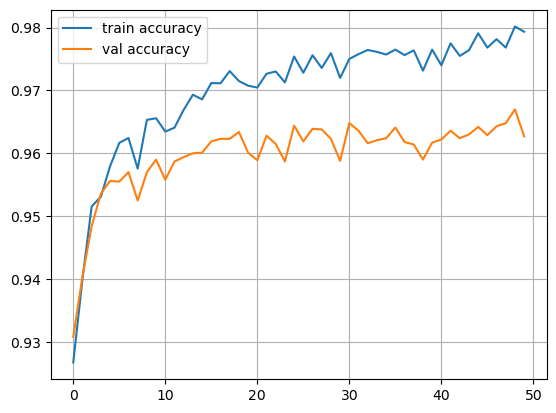

In [57]:
for epoch in range(50):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)

    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))

    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


### Сравнение результатов
#### Для 30 эпох
До BatchNorm было
```
Train accuracy: 0.98532
Val accuracy: 0.9713
```
```
BatchNorm до ReLu:
Train accuracy: 0....
Val accuracy: 0.96
```

```
BatchNorm после ReLu:
Train accuracy: 0.93122
Val accuracy: 0.9282
```

Скоры на трейне и на валидации почти одинаковые
### Для 50 эпох
```
Train accuracy: 0.97934
Val accuracy: 0.9627
```

BatchNorm не улучшил результат

## Нейросеть для извлечения представлений
Помимо собственно классификации, нейросети часто используют для получения векторных описаний (embeddings) объектов различной природы. Часто в качестве представлений можно взять просто векторы активаций нейронов с одного из последних слоев. Вычислим такие представления:

In [60]:
train_activations = forward(network, X_train)
train_hidden_representations = train_activations[2]
test_activations = forward(network, X_test)
test_hidden_representations = test_activations[2]

Полученные представления можно использовать в любых целях, в комбинации с другими инструментами машинного обучения.
Сравним обученные представления для изображений из MNIST c исходными 784-мерными представлениями. Постройте t-SNE визуализации 1000 случайных изображений из X_train, полученные на основе исходных 784-мерных представлений и обученных представлений. Сделайте вывод о качестве представлений.

In [61]:
from util import plot_embedding
from sklearn.manifold import TSNE
subset_ids = np.random.permutation(X_train.shape[0])[:1000]
tsne =TSNE()
dataset = X_train[subset_ids]
# We use [2] in order to get one of the hidden representations from all of them
x_learnt_tsne = tsne.fit_transform(np.array(forward(network, dataset)[2]))
x_original_tsne = tsne.fit_transform(dataset)

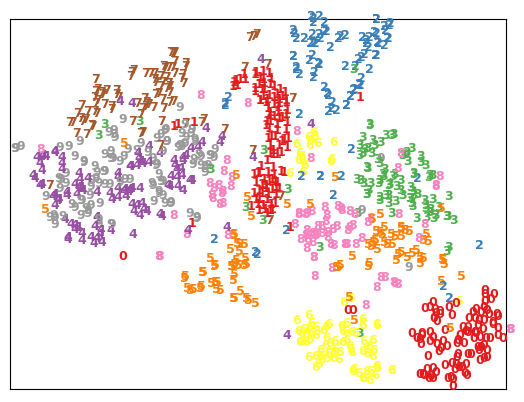

In [211]:
plot_embedding(x_original_tsne, y_train[subset_ids])

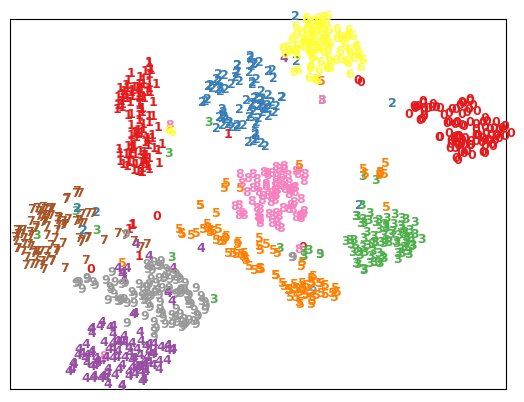

In [212]:
plot_embedding(x_learnt_tsne, y_train[subset_ids])

Наконец, исследуем универсальность полученных представлений. Используем их для решения другой задачи классификации: предсказание четности изображенной цифры.

In [62]:
new_y_train = y_train % 2
new_y_test = y_test % 2

Обучите простейшую логистическую регресиию, предсказывающую четность изображенной цифры, используя в качестве вектора признаков:

1) исходные 784-мерные представления

2) обученные представления

Сравните качество и сделайте вывод об универсальности обученных представлений.

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lr = LogisticRegression(solver="lbfgs")

In [69]:
#Initial representation
lr.fit(tsne.fit_transform(X_train), new_y_train)
y_pred = lr.predict(tsne.fit_transform(X_test))


In [70]:
accuracy = accuracy_score(y_pred, new_y_test)
accuracy

0.5946

In [71]:
lr.fit(tsne.fit_transform(np.array(forward(network, X_train)[2])), new_y_train)
y_pred = lr.predict(tsne.fit_transform(np.array(forward(network, X_test)[2])))


In [72]:
accuracy = accuracy_score(y_pred, new_y_test)
accuracy

ValueError: Found input variables with inconsistent numbers of samples: [50000, 10000]